# Digit Recognizer data set

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

## Load data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We see that the train set contains 42000 rows, each corresponds to an image of a digit represnted by pixel values. The test set contains 28000 images but without the label column.

## Take a look at a few of them

In [7]:
labels = train.label
train.drop('label', axis=1, inplace=True)

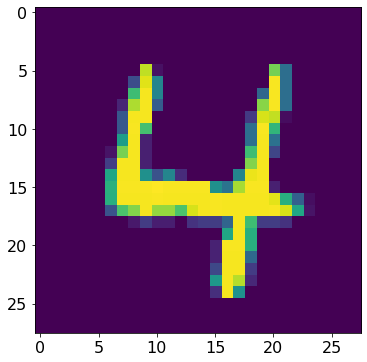

In [8]:
plt.imshow(train.iloc[42].values.reshape((28, 28)))

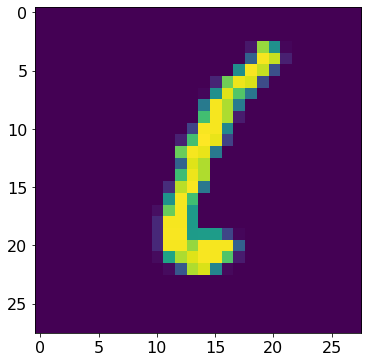

In [9]:
plt.imshow(train.iloc[41275].values.reshape((28, 28)))

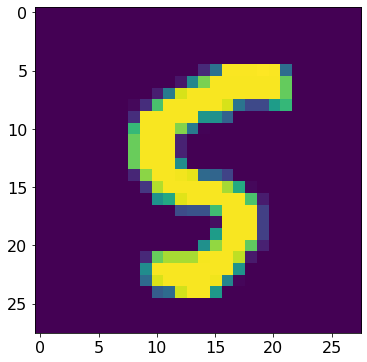

In [10]:
plt.imshow(train.iloc[20452].values.reshape((28, 28)))

## Preprocessing
before we start building a model we first normalize the pixel values, split the training data in to train and validation sets

In [11]:
train = train.values / 255
test = test.values / 255
train = train.reshape((-1, 28, 28, 1))
test = test.reshape((-1, 28, 28, 1))
labels = labels.values
labels = to_categorical(labels)
X_train, X_val, y_train, y_val = train_test_split(train, labels, test_size=0.2)

## Data augmentation

In [12]:
data_gen = ImageDataGenerator(rotation_range=15, zoom_range = 0.1,
                             width_shift_range=0.1, height_shift_range=0.1)

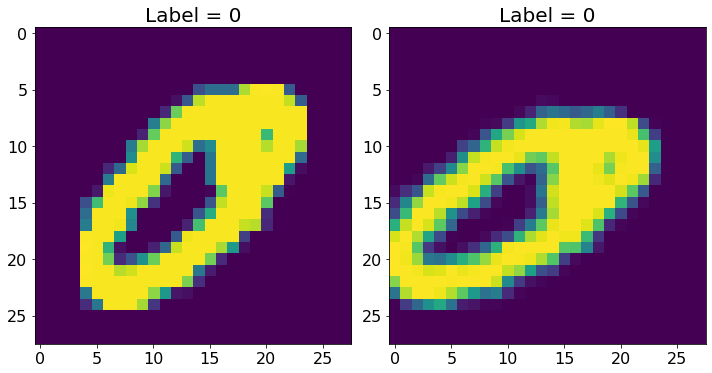

In [13]:
index = np.random.randint(0, X_train.shape[0])
example_img = X_train[index].reshape((1, 28, 28, 1))
example_label = y_train[index].reshape((1, 10))
mod_img, mod_label = data_gen.flow(example_img, example_label).next()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].imshow(example_img[0, :, :, 0])
axes[0].set_title(f'Label = {np.argmax(example_label)}')

axes[1].imshow(mod_img[0, :, :, 0])
axes[1].set_title(f'Label = {np.argmax(mod_label)}')

plt.tight_layout()

## Initialize GPU (only for my local machine

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Train 20 CNNs

In [15]:
num_models = 20
models = []

for i in range(num_models):
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=[28, 28, 1]))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2))
    model.add(Dropout(0.5))
    
    # Block 2
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2))
    model.add(Dropout(0.5))
    
    #Block 3
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    models.append(model)

In [16]:
batch_size = 64
num_epochs = 40

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, min_lr=0.00001)

history = []
for i in range(num_models):
    hist = models[i].fit_generator(data_gen.flow(X_train, y_train, batch_size=batch_size),
                                   epochs=num_epochs, steps_per_epoch=X_train.shape[0] // batch_size,  
                                   validation_data = (X_val, y_val), callbacks=[reduce_lr], verbose=0)
    
    print(f"Model {i + 1}, after {num_epochs} epochs, train accuracy = {hist.history['accuracy'][-1]:.4f}, "
          f"validation accuracy={hist.history['val_accuracy'][-1]:.4f}")
    history.append(hist)

Model 1, after 40, train accuracy = 0.9861, validation accuracy=0.9931
Model 2, after 40, train accuracy = 0.9890, validation accuracy=0.9938
Model 3, after 40, train accuracy = 0.9878, validation accuracy=0.9937
Model 4, after 40, train accuracy = 0.9874, validation accuracy=0.9940
Model 5, after 40, train accuracy = 0.9886, validation accuracy=0.9938
Model 6, after 40, train accuracy = 0.9867, validation accuracy=0.9930
Model 7, after 40, train accuracy = 0.9872, validation accuracy=0.9938
Model 8, after 40, train accuracy = 0.9901, validation accuracy=0.9946
Model 9, after 40, train accuracy = 0.9856, validation accuracy=0.9936
Model 10, after 40, train accuracy = 0.9899, validation accuracy=0.9942
Model 11, after 40, train accuracy = 0.9865, validation accuracy=0.9939
Model 12, after 40, train accuracy = 0.9887, validation accuracy=0.9931
Model 13, after 40, train accuracy = 0.9866, validation accuracy=0.9937
Model 14, after 40, train accuracy = 0.9889, validation accuracy=0.9938
M

## Make prediction

In [17]:
results = np.zeros((test.shape[0], 10))
for i in range(num_models):
    results += models[i].predict(test)
    
pred = np.argmax(results, axis=1)

In [18]:
output = pd.DataFrame({'ImageId': np.arange(1, test.shape[0] + 1), 'Label': pred})
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [19]:
output.to_csv('output.csv', index=False)

In [22]:
for i in range(num_models):
    models[i].save(f'../models/model_{i}.h5')